In [1]:
import os
import librosa
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal import spectrogram, find_peaks
from scipy.io import wavfile
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import seaborn as sns


In [2]:
def find_harmonics(path, print_peaks=False):
    fs, X = wavfile.read(path)
    N = len(X)
    X_F = fft(X)
    X_F_onesided = 2.0/N * np.abs(X_F[0:N//2])
    freqs = fftfreq(N, 1/fs)[:N//2]
    freqs_50_index = np.abs(freqs - 50).argmin()
    
    h = X_F_onesided.max()*5/100
    peaks, _ = find_peaks(X_F_onesided, distance=10, height = h)
    ht=np.array(_['peak_heights'])
    harmonics = np.round(freqs[peaks])
    if print_peaks:
        i = peaks.max() + 100
        plt.plot(freqs[:i], X_F_onesided[:i])
        plt.plot(freqs[peaks], X_F_onesided[peaks], "x")
        plt.xlabel('Frequency in Hz')
        plt.show()
    return harmonics,np.round(ht)

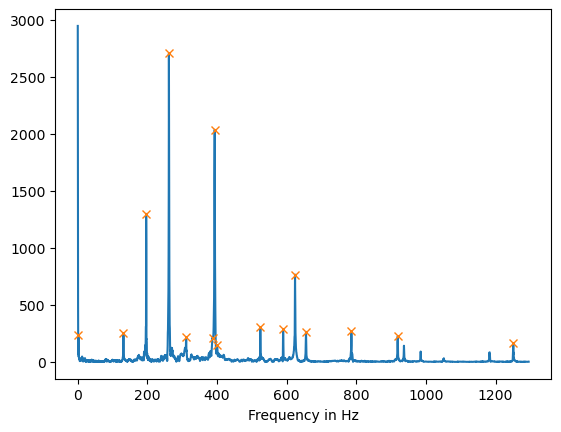

Harmonics: [   2.  131.  196.  262.  312.  388.  393.  400.  524.  590.  624.  656.
  786.  919. 1251.]
[ 238.  252. 1298. 2704.  214.  213. 2035.  149.  304.  289.  765.  264.
  269.  225.  162.]


In [3]:
path = "./af/Minor/Minor_1.wav"
harmonics_2,ht = find_harmonics(path, print_peaks=1)
print("Harmonics: {}".format(np.round(harmonics_2)))
print(ht)

In [4]:
def sort_dict_by_keys(d):
    sorted_dict = dict(sorted(d.items(), reverse=True))
    return sorted(list(sorted_dict.values())[:8])

In [5]:
d={}
for i in range(len(ht)):
    d[ht[i]]=harmonics_2[i]
d

{238.0: 2.0,
 252.0: 131.0,
 1298.0: 196.0,
 2704.0: 262.0,
 214.0: 312.0,
 213.0: 388.0,
 2035.0: 393.0,
 149.0: 400.0,
 304.0: 524.0,
 289.0: 590.0,
 765.0: 624.0,
 264.0: 656.0,
 269.0: 786.0,
 225.0: 919.0,
 162.0: 1251.0}

In [6]:
sort_dict_by_keys(d)

[196.0, 262.0, 393.0, 524.0, 590.0, 624.0, 656.0, 786.0]

In [8]:
path = "./af"
data = []

for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        foldername = os.path.basename(dirname)
        full_path = os.path.join(dirname, filename)
        freq_peaks,ht = find_harmonics(full_path)
        d={}
        for i in range(len(ht)):
            d[ht[i]]=freq_peaks[i]
        cur_data = [foldername, filename]
        cur_data.extend([freq_peaks.min(), freq_peaks.max(), len(freq_peaks)])
        cur_data.extend(sort_dict_by_keys(d))
        data.append(cur_data)

In [9]:
cols = ["Output", "fn", "Min", "Max", "number"]
for i in range(8):
    cols.append("Harmonic number {}".format(i+1))

df = pd.DataFrame(data, columns=cols)
df.head()

,Output,fn,Min,Max,number,Harmonic number 1,Harmonic number 2,Harmonic number 3,Harmonic number 4,Harmonic number 5,Harmonic number 6,Harmonic number 7,Harmonic number 8
0,Major,Major_0.wav,131.0,1838.0,21,131.0,196.0,262.0,330.0,392.0,496.0,525.0,588.0
1,Major,Major_1.wav,2.0,993.0,17,165.0,196.0,262.0,331.0,392.0,496.0,524.0,661.0
2,Major,Major_10.wav,131.0,1409.0,20,131.0,185.0,234.0,262.0,330.0,370.0,468.0,659.0
3,Major,Major_100.wav,155.0,2449.0,27,196.0,278.0,311.0,392.0,467.0,556.0,588.0,835.0
4,Major,Major_101.wav,156.0,1094.0,20,156.0,197.0,278.0,311.0,350.0,393.0,556.0,624.0


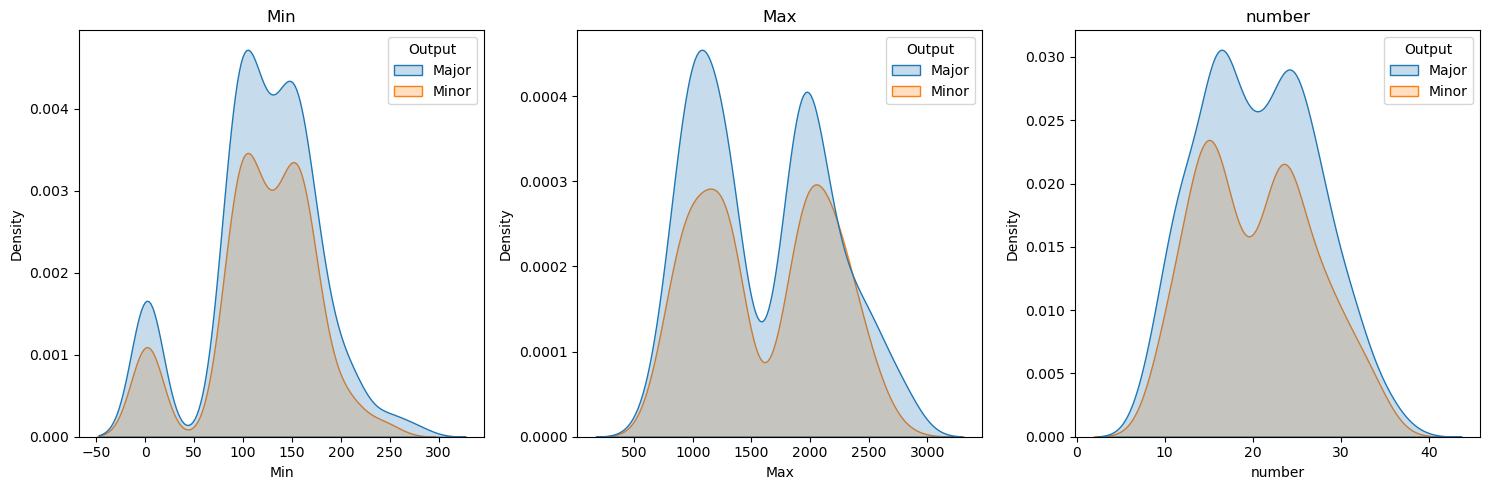

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.kdeplot(ax=axes[0], data=df, x="Min", hue="Output", fill=True)
sns.kdeplot(ax=axes[1], data=df, x="Max", hue="Output", fill=True)
sns.kdeplot(ax=axes[2], data=df, x="number", hue="Output", fill=True)
axes[0].set_title("Min")
axes[1].set_title("Max")
axes[2].set_title("number")
fig.tight_layout()
plt.show()

In [13]:
df_original = df.copy()

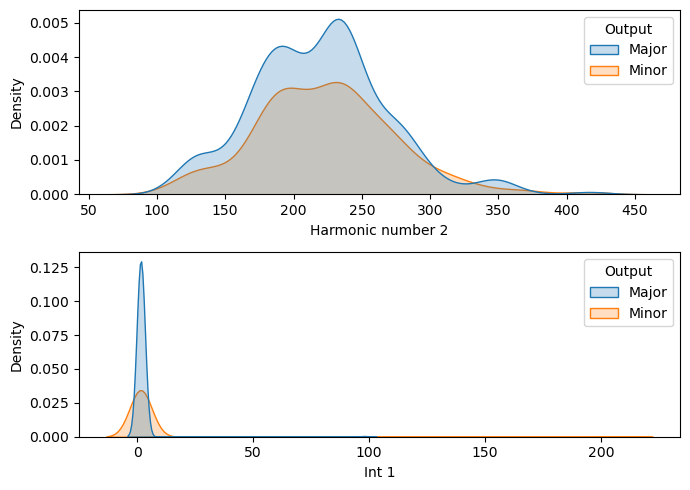

In [14]:
df["Int 1"] = df["Harmonic number 2"].div(df["Harmonic number 1"], axis=0)

fig, axes = plt.subplots(2, 1, figsize=(7, 5))
sns.kdeplot(ax=axes[0], data=df, x="Harmonic number 2", hue="Output", fill=True)
sns.kdeplot(ax=axes[1], data=df, x="Int 1", hue="Output", fill=True)
fig.tight_layout()
plt.show()

In [15]:
df = df_original.copy()

In [16]:
for i in range(1,8):
    ci = "Int {}".format(i)
    cu = "Harmonic number {}".format(i+1)
    ph = "Harmonic number {}".format(i)
    df[ci] = df[cu].div(df[ph], axis=0)
    
df.head(25)

,Output,fn,Min,Max,number,Harmonic number 1,Harmonic number 2,Harmonic number 3,Harmonic number 4,Harmonic number 5,Harmonic number 6,Harmonic number 7,Harmonic number 8,Int 1,Int 2,Int 3,Int 4,Int 5,Int 6,Int 7
0,Major,Major_0.wav,131.0,1838.0,21,131.0,196.0,262.0,330.0,392.0,496.0,525.0,588.0,1.496183,1.336735,1.259542,1.187879,1.265306,1.058468,1.120000
1,Major,Major_1.wav,2.0,993.0,17,165.0,196.0,262.0,331.0,392.0,496.0,524.0,661.0,1.187879,1.336735,1.263359,1.184290,1.265306,1.056452,1.261450
2,Major,Major_10.wav,131.0,1409.0,20,131.0,185.0,234.0,262.0,330.0,370.0,468.0,659.0,1.412214,1.264865,1.119658,1.259542,1.121212,1.264865,1.408120
3,Major,Major_100.wav,155.0,2449.0,27,196.0,278.0,311.0,392.0,467.0,556.0,588.0,835.0,1.418367,1.118705,1.260450,1.191327,1.190578,1.057554,1.420068
4,Major,Major_101.wav,156.0,1094.0,20,156.0,197.0,278.0,311.0,350.0,393.0,556.0,624.0,1.262821,1.411168,1.118705,1.125402,1.122857,1.414758,1.122302
5,Major,Major_102.wav,156.0,2472.0,32,196.0,278.0,311.0,392.0,467.0,494.0,556.0,588.0,1.418367,1.118705,1.260450,1.191327,1.057816,1.125506,1.057554
6,Major,Major_103.wav,156.0,1053.0,21,156.0,196.0,278.0,311.0,350.0,392.0,494.0,556.0,1.256410,1.418367,1.118705,1.125402,1.120000,1.260204,1.125506
7,Major,Major_104.wav,155.0,2449.0,24,196.0,295.0,311.0,350.0,392.0,467.0,589.0,699.0,1.505102,1.054237,1.125402,1.120000,1.191327,1.261242,1.186757
8,Major,Major_105.wav,156.0,1053.0,13,156.0,197.0,294.0,311.0,350.0,393.0,589.0,624.0,1.262821,1.492386,1.057823,1.125402,1.122857,1.498728,1.059423
9,Major,Major_106.wav,155.0,2097.0,24,155.0,278.0,311.0,392.0,467.0,524.0,556.0,835.0,1.793548,1.118705,1.260450,1.191327,1.122056,1.061069,1.501799


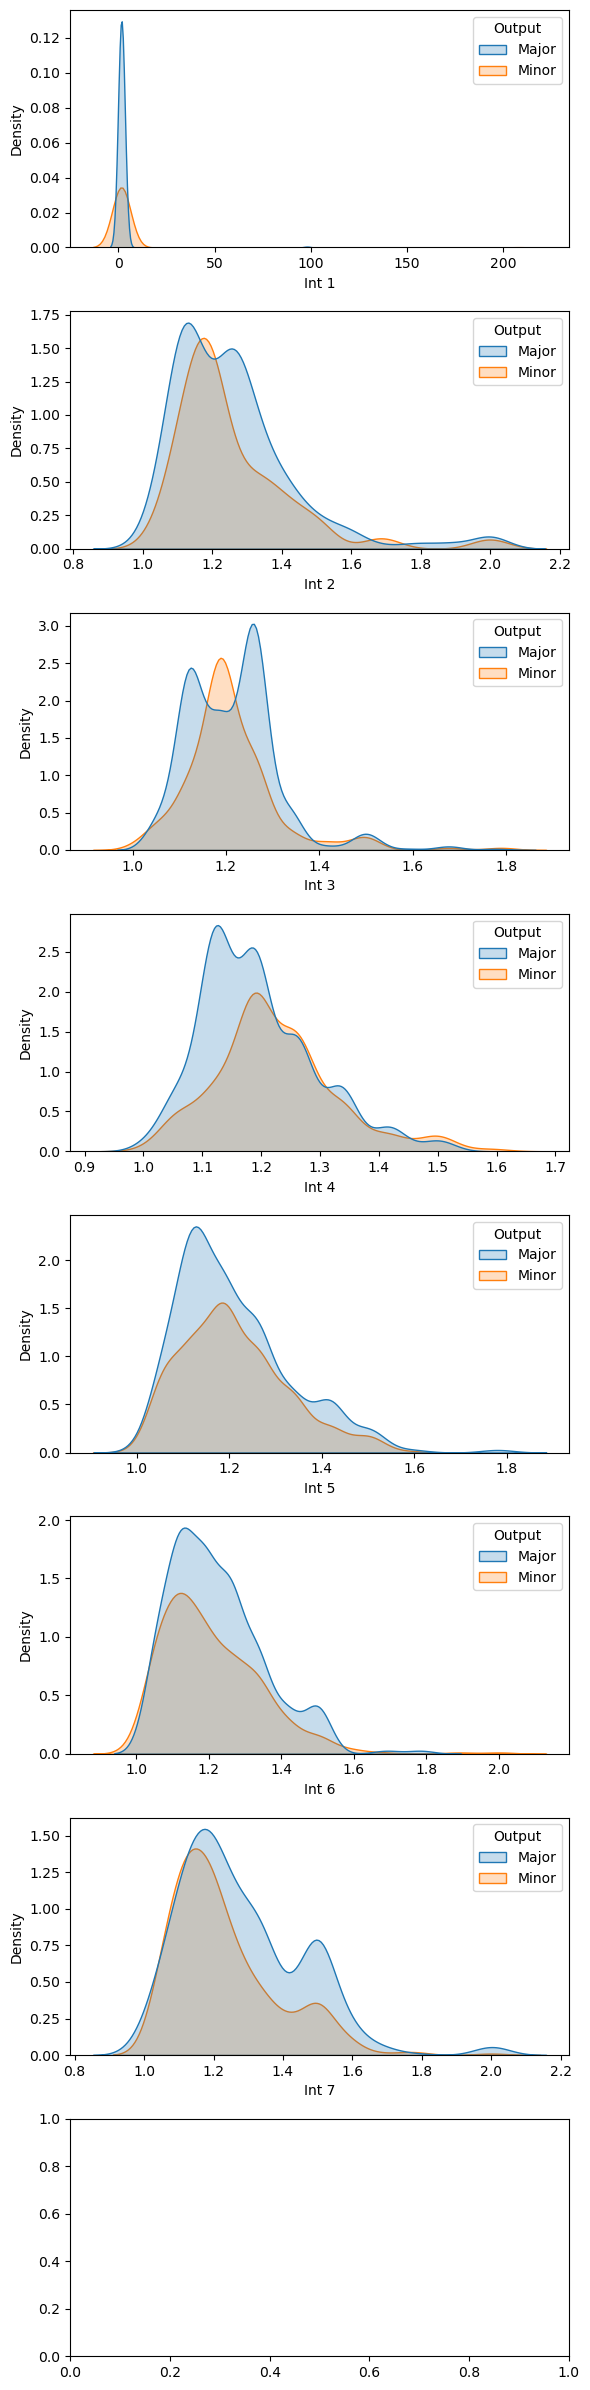

In [17]:
fig, axes = plt.subplots(nrows=8, figsize=(6,24))

for i in range(1, 8):
    plt.subplot(8, 1, i)
    sns.kdeplot(data=df, x="Int {}".format(i), hue="Output", fill=True)
plt.tight_layout()
plt.show()

In [19]:
df["Output"] = df["Output"].replace("Major", 1)
df["Output"] = df["Output"].replace("Minor", 0)

In [82]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df['sInt 1'] = scaler.fit_transform(df[['Int 1']])
df['sInt 2'] = scaler.fit_transform(df[['Int 2']])
df['sInt 3'] = scaler.fit_transform(df[['Int 3']])
df['sInt 4'] = scaler.fit_transform(df[['Int 4']])

In [83]:
print(df.columns)

Index(['Output', 'fn', 'Min', 'Max', 'number', 'Harmonic number 1',
       'Harmonic number 2', 'Harmonic number 3', 'Harmonic number 4',
       'Harmonic number 5', 'Harmonic number 6', 'Harmonic number 7',
       'Harmonic number 8', 'Int 1', 'Int 2', 'Int 3', 'Int 4', 'Int 5',
       'Int 6', 'Int 7', 'sInt 1', 'sInt 2', 'sInt 3', 'sInt 4'],
      dtype='object')


In [84]:
df.head()

,Output,fn,Min,Max,number,Harmonic number 1,Harmonic number 2,Harmonic number 3,Harmonic number 4,Harmonic number 5,...,Int 2,Int 3,Int 4,Int 5,Int 6,Int 7,sInt 1,sInt 2,sInt 3,sInt 4
0,1,Major_0.wav,131.0,1838.0,21,131.0,196.0,262.0,330.0,392.0,...,1.336735,1.259542,1.187879,1.265306,1.058468,1.120000,0.002134,0.326981,0.318273,0.307324
1,1,Major_1.wav,2.0,993.0,17,165.0,196.0,262.0,331.0,392.0,...,1.336735,1.263359,1.184290,1.265306,1.056452,1.261450,0.000644,0.326981,0.323185,0.301120
2,1,Major_10.wav,131.0,1409.0,20,131.0,185.0,234.0,262.0,330.0,...,1.264865,1.119658,1.259542,1.121212,1.264865,1.408120,0.001728,0.254054,0.138223,0.431208
3,1,Major_100.wav,155.0,2449.0,27,196.0,278.0,311.0,392.0,467.0,...,1.118705,1.260450,1.191327,1.190578,1.057554,1.420068,0.001758,0.105745,0.319441,0.313284
4,1,Major_101.wav,156.0,1094.0,20,156.0,197.0,278.0,311.0,350.0,...,1.411168,1.118705,1.125402,1.122857,1.414758,1.122302,0.001006,0.402508,0.136996,0.199320


In [91]:
df.to_csv('dataframe.csv',index=False)

In [88]:
columns = ['Harmonic number 1',
       'Harmonic number 2', 'Harmonic number 3', 'Harmonic number 4',
       'Harmonic number 5', 'Harmonic number 6', 'Harmonic number 7',
       'Harmonic number 8','sInt 1','sInt 2','sInt 3','sInt 4']
train_X, val_X, train_y, val_y = train_test_split(df[columns], df["Output"], test_size=0.40, random_state=0)
train_X.head()

,Harmonic number 1,Harmonic number 2,Harmonic number 3,Harmonic number 4,Harmonic number 5,Harmonic number 6,Harmonic number 7,Harmonic number 8,sInt 1,sInt 2,sInt 3,sInt 4
585,186.0,208.0,247.0,312.0,371.0,467.0,556.0,624.0,0.000308,0.175551,0.322927,0.309439
403,104.0,186.0,208.0,233.0,262.0,312.0,371.0,556.0,0.003546,0.105313,0.138911,0.197698
532,165.0,185.0,278.0,331.0,440.0,496.0,556.0,661.0,0.000322,0.495390,0.229596,0.551807
104,93.0,186.0,234.0,278.0,311.0,350.0,467.0,556.0,0.004569,0.247154,0.226232,0.187743
303,247.0,350.0,393.0,495.0,743.0,786.0,1053.0,1241.0,0.001751,0.109958,0.318273,0.848633


In [89]:
lr = LogisticRegression(random_state=0,max_iter=1000)
rfc = RandomForestClassifier(random_state=0)

score_lr = cross_val_score(lr, train_X, train_y, cv=2).mean()
score_rfc = cross_val_score(rfc, train_X, train_y, cv=2).mean()

In [90]:
print("Cross Val Score for Logistic Regression: {:.2f}".format(score_lr))
print("Cross Val Score for Random Forest Classifier: {:.2f}".format(score_rfc))

Cross Val Score for Logistic Regression: 0.56
Cross Val Score for Random Forest Classifier: 0.74


<AxesSubplot: xlabel='Harmonic number 1', ylabel='Density'>

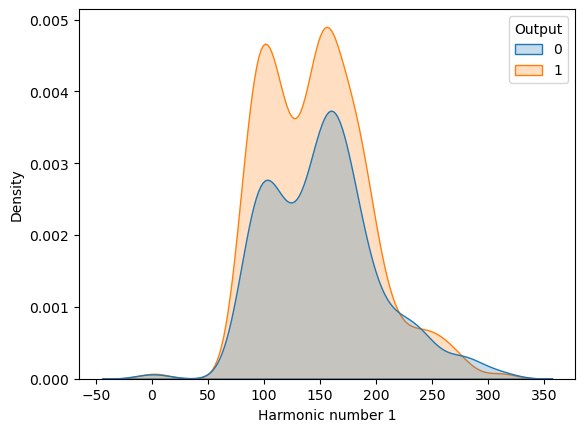

In [337]:
sns.kdeplot(data=df, x="Harmonic number 1", hue="Output", fill=True)

<AxesSubplot: xlabel='Harmonic number 2', ylabel='Density'>

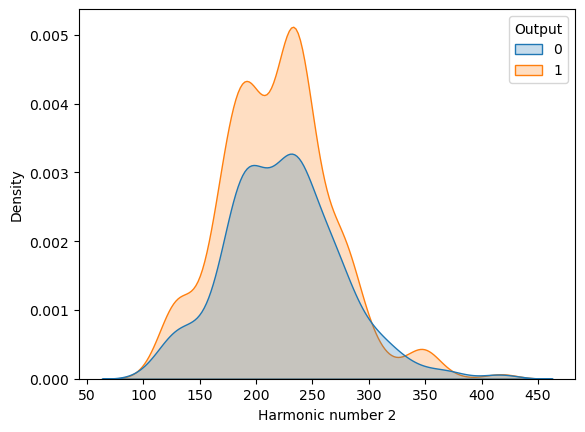

In [324]:
sns.kdeplot(data=df, x="Harmonic number 2", hue="Output", fill=True)

<AxesSubplot: xlabel='Harmonic number 3', ylabel='Density'>

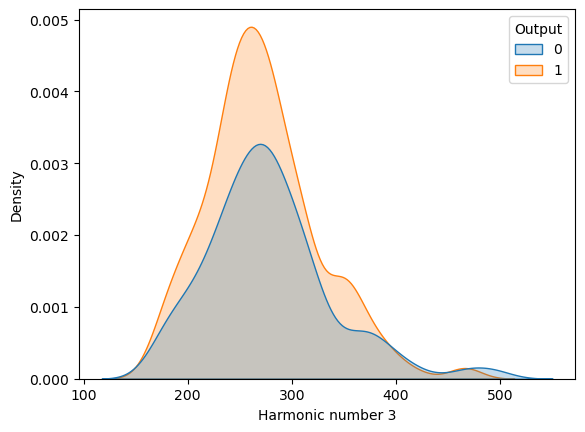

In [325]:
sns.kdeplot(data=df, x="Harmonic number 3", hue="Output", fill=True)

<AxesSubplot: xlabel='Harmonic number 4', ylabel='Density'>

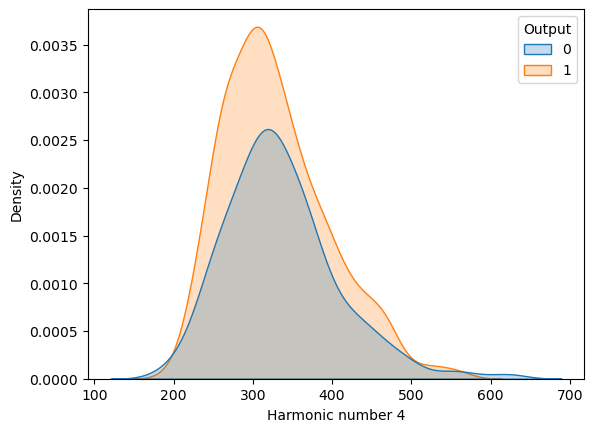

In [326]:
sns.kdeplot(data=df, x="Harmonic number 4", hue="Output", fill=True)

<AxesSubplot: xlabel='Harmonic number 5', ylabel='Density'>

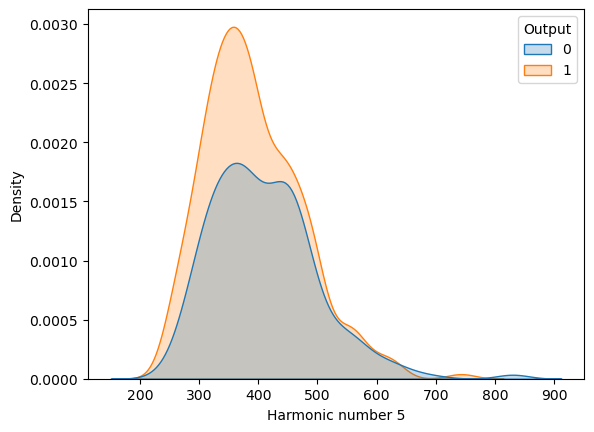

In [327]:
sns.kdeplot(data=df, x="Harmonic number 5", hue="Output", fill=True)

<AxesSubplot: xlabel='Harmonic number 6', ylabel='Density'>

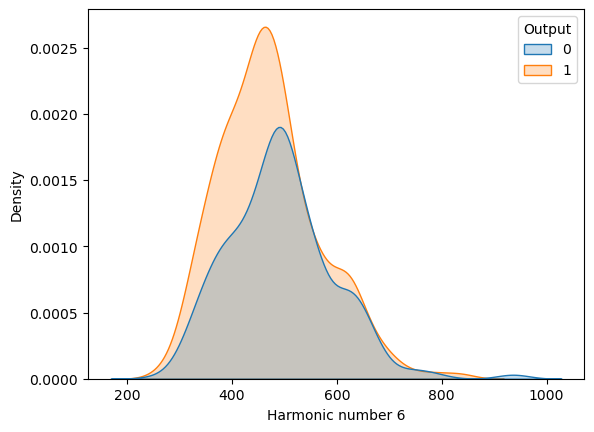

In [328]:
sns.kdeplot(data=df, x="Harmonic number 6", hue="Output", fill=True)

<AxesSubplot: xlabel='Harmonic number 7', ylabel='Density'>

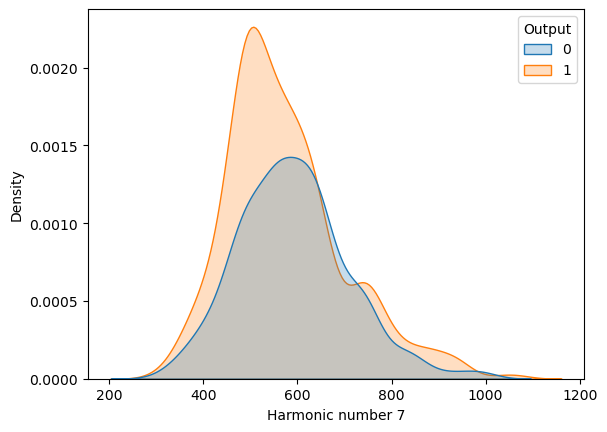

In [329]:
sns.kdeplot(data=df, x="Harmonic number 7", hue="Output", fill=True)

<AxesSubplot: xlabel='Harmonic number 8', ylabel='Density'>

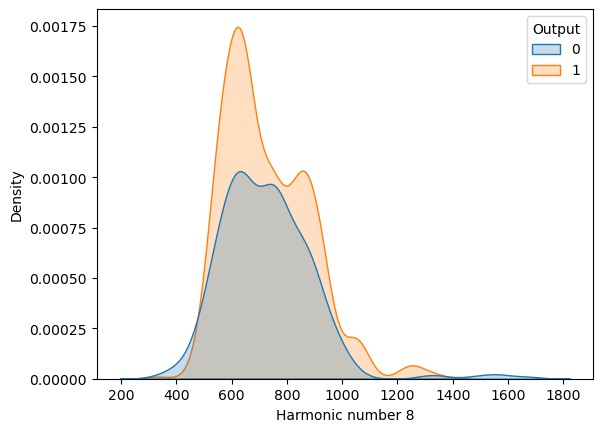

In [330]:
sns.kdeplot(data=df, x="Harmonic number 8", hue="Output", fill=True)